In [86]:
from MNIST_dataloader import Noisy_MNIST
from Fast_MRI_dataloader import Fast_MRI
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torch.utils.data import TensorDataset
import glob
import numpy as np
from tqdm import tqdm 
from PIL import Image
import numpy as np
import scipy.fft as fft


In [72]:
# Bram
data_loc = 'D://5LSL0-Datasets//Fast_MRI_Knee' #change the datalocation to something that works for you

In [117]:
# %% dataloader for the Fast MRI dataset
def create_dataloaders_mri(data_loc, batch_size):
    dataset_train = Fast_MRI("train", data_loc)
    dataset_test  = Fast_MRI("test" , data_loc)
    
    Fast_MRI_train_loader =  DataLoader(dataset_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Fast_MRI_test_loader  =  DataLoader(dataset_test , batch_size=batch_size, shuffle=True, drop_last=False)
    
    return Fast_MRI_train_loader, Fast_MRI_test_loader

In [118]:
batch_size = 32
create_dataloaders_mri(data_loc, batch_size)
train_loader, test_loader = create_dataloaders_mri(data_loc, batch_size)

In [119]:
# get some examples
training_set = enumerate(train_loader)
_, (k_space, masks, gt) = next(training_set)

In [120]:
def ista_accelerated_mri(mu, lam, K, k_space, masks):
    # Convert k_space and masks to NumPy arrays
    k_space = k_space.numpy()
    masks = masks.numpy()

    # Initialize the reconstruction
    x = np.zeros_like(k_space)

    for _ in range(K):
        # Apply the forward Fourier transform
        Fx = fft.fft2(x)

        # Compute the data consistency term
        M_Fx = masks * Fx
        M_Fy = masks * k_space
        data_consistency = fft.ifft2(M_Fx - M_Fy)

        # Update the reconstruction
        x = np.real(fft.ifft2(Fx - mu * M_Fx + mu * M_Fy))
        x = np.sign(x) * np.maximum(np.abs(x) - lam * mu, 0.0)

    return x



In [121]:
mu = 0.00001
K = 2000
lam = 0.4
x = ista_accelerated_mri(mu, lam, K, k_space, masks)


KeyboardInterrupt: 

In [122]:
def create_image_from_reconstruction(x):
    # Apply the inverse Fourier transform
    image = np.abs(fft.ifftshift(fft.ifft2(x)))

    # Normalize the image intensity
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    return image

reconstructed_image = create_image_from_reconstruction(x)

In [123]:
reconstructed_image[0]

array([[0.389974  , 0.15214356, 0.14867466, ..., 0.10144782, 0.14867466,
        0.15214356],
       [0.13020269, 0.10527344, 0.08057704, ..., 0.04184012, 0.09725982,
        0.06317533],
       [0.09382897, 0.13069803, 0.01797228, ..., 0.0756556 , 0.0278744 ,
        0.06171831],
       ...,
       [0.05170012, 0.05831235, 0.0183054 , ..., 0.01761665, 0.02386827,
        0.0222868 ],
       [0.09382897, 0.06171831, 0.0278744 , ..., 0.08081057, 0.01797228,
        0.13069803],
       [0.13020269, 0.06317533, 0.09725982, ..., 0.09957386, 0.08057704,
        0.10527344]])

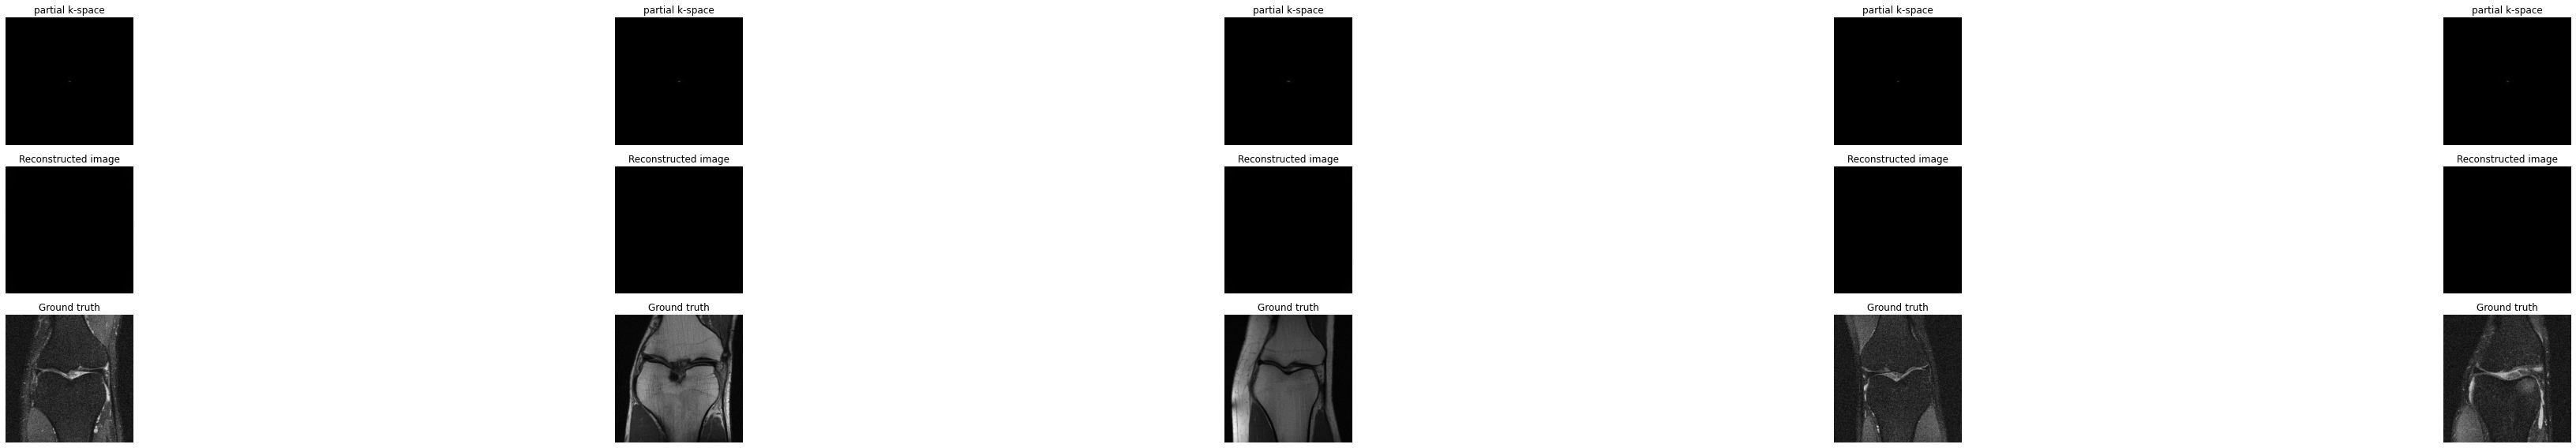

In [104]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(6 * 10, 8))

for i in range(5):
#    # Get the clear image and denoised image for the current iteration
     # denoised_image_np = denoised_images
     # clear_image_np = input_images

#    # Plot the denoised image in the first row of subplots
     axes[0, i].imshow(magnitude_image[i], cmap='gray')
     axes[0, i].set_title('partial k-space')
     axes[0, i].axis('off')  

#     # Plot the denoised image in the first row of subplots
     axes[1, i].imshow(reconstructed_image[i], cmap='gray')
     axes[1, i].set_title('Reconstructed image')
     axes[1, i].axis('off')  

#     # Plot the clear image in the second row of subplots
     axes[2, i].imshow(gt[i], cmap='gray')
     axes[2, i].set_title('Ground truth')
     axes[2, i].axis('off')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
